[*********************100%***********************]  1 of 1 completed
(17, 755, 5)


<Figure size 432x288 with 0 Axes>

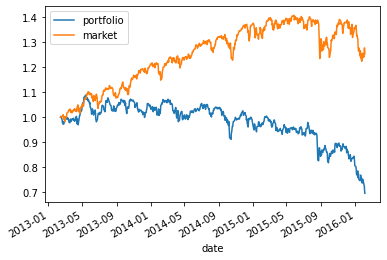

In [1]:
from src.environments.portfolio_end import PortfolioEnd
import numpy as np

p = PortfolioEnd("2013-02-13", "2016-02-05", 4, continuous=False)
print(p.market.data.shape)

p.reset()
while True:
    action = p.action_space.sample()
    action /= action.sum()
    #action = np.zeros(17)
    #action[1] = 1
    a,b,c,d = p.step(action)
    if c:
        break

p.render()

In [49]:
%env PYTHONPATH=E:/Polito/Tesi/rl_portfolio_management

%matplotlib inline
!python src/agents/agents_evaluator.py

env: PYTHONPATH=E:/Polito/Tesi/rl_portfolio_management

[*********************100%***********************]  1 of 1 completed
Begin eval!
Begin eval!
Figure(640x480)
Figure(640x480)
       sharpe_ratio  sortino_ratio  max_drawdown    var_95   cvar_95
agent                                                               
ddpg       1.775063       2.513189     -0.063463 -0.009211 -0.017582
crp        1.787613       2.531172     -0.063199 -0.009182 -0.017610


(750.0, 2000.0)

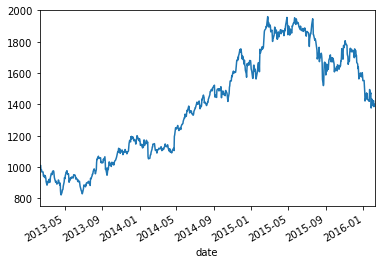

In [4]:
import pandas as pd

a = pd.read_csv('data/AAPL_data.csv')
a['date'] = pd.to_datetime(a['date'], format='%Y-%m-%d')
a.set_index('date', inplace=True)
a['close'] = a['close'].apply(lambda x : x / a.iloc[0]['close'] * 1000)
ax = a['close'].plot()
ax.set_xlim(pd.Timestamp('2013-02-08'), pd.Timestamp('2016-02-07'))
ax.set_ylim(750, 2000)